# Linear Regression Using Scikit-Learn

This is the first in a series of notebooks focusing on applying the best practices of the `scikit-learn` API to standard ML tasks.
The goal of these notebooks is to streamline the `scikit-learn` data science workflow.

## Importing the Libraries

In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_boston
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

warnings.filterwarnings('ignore')

## Importing the Dataset

In [2]:
boston = load_boston()

In [3]:
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Data Description and Problem Definition

In [4]:
## Boston Dataset Metadata description
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

This is the famous `boston` dataset. It contains features about residential properties that have been sold in the past. The goal is to use the features set to predict the target, `MEDV`, the median value of the residential property. This is a linear regression prediction task, where we try finding a line that best fits our training data and is a suitable predictor of the median value of new residential properties on the market, given their features.

## Data Pre-Processing

Before we get to the training of our model, we have to perform a series of task that are important in ensuring that we are building an accurate and valid model. These data pre-processing steps are often a series of sanity checks that we perform to ensure that our data is in the right format and shape before being passed as an input to the Machine Learning model.

Data Pre-Processing almost always involves the following steps - 
  1. Handling missing values.
  2. Splitting the data into $X$ (**features**) and $y$ (**target**).
  3. Feature scaling and standardization.
  4. Label encoding.
  5. Splitting the data into **training**, **testing** and **validation** sets.
  6. Handling Imbalance in the data.

### Handling Missing Values

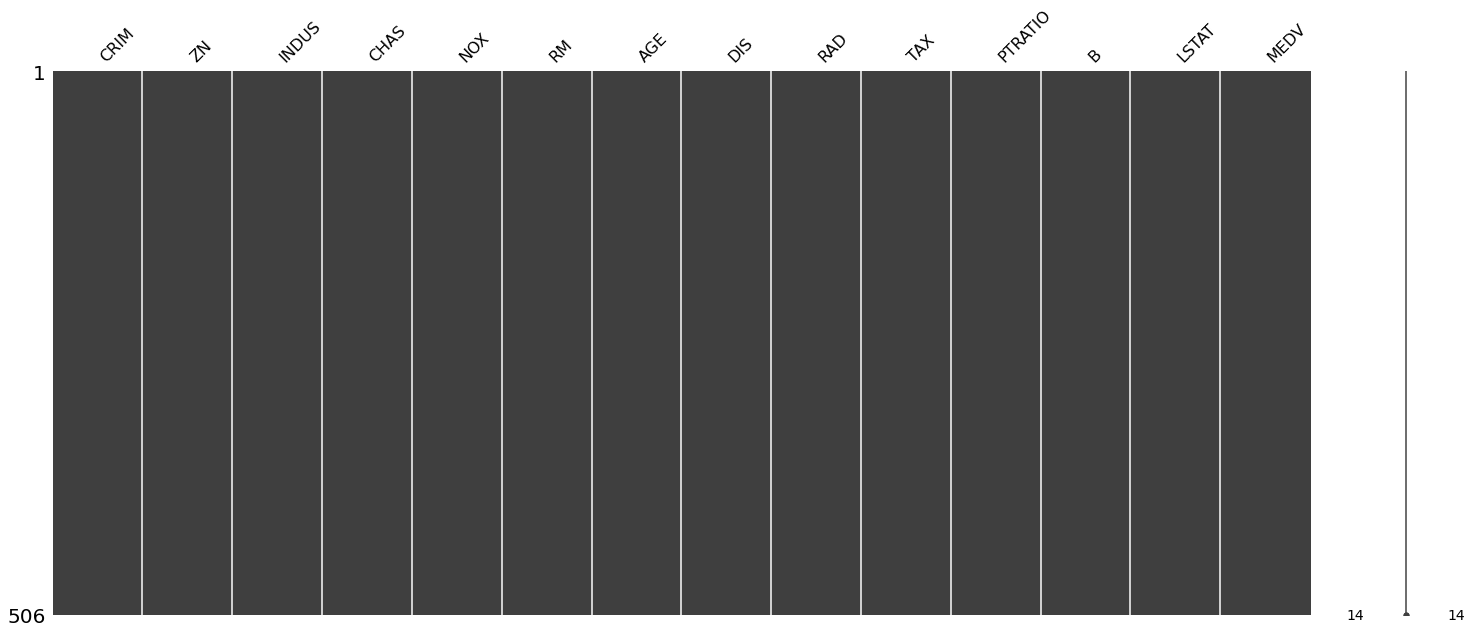

In [5]:
msno.matrix(df);

Our data does not have any missing values, we do not need to worry about imputing them in.

### Splitting our Data into $X$ and $y$

We separate out our dataset features into a matrix, $X$ and our target into a vector, $y$.

In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

### Feature Scaling and Standardization

All of our features are numeric. Let's take a look at their numerical properties.

In [9]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Our features have values in varying orders of magnitude. While some are proportions, others are indices and some more are raw values. Since we are building a distance based linear regressor, we must apply standardization to our features.

**Standardization** involves centering the variables so that the predictors have mean 0. This makes it easier to interpret the intercept term as the expected value of $Y_{i}$ when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of $Y_{i}$ when the predictors are set to 0, which may not be a realistic or interpretable.

Another practical reason for scaling in regression is when one variable has a very large scale, In that case, the regression coefficients may be on a very small order of magnitude which can be a little annoying when you're reading computer output, so you may convert the variable to, for example, population size in millions. The convention that you standardize predictions primarily exists so that the units of the regression coefficients are the same. 

**Centering/scaling does not affect the statistical inference in regression models - the estimates are adjusted appropriately and the p-values will be the same.**

In [10]:
## This initializes an instance of the `StandardScalar` class
# sc = StandardScaler()

### Label Encoding/One Hot Encoding

Machine learning algorithms cannot operate directly on labeled data. They require all input and output variables to be numeric. This is mostly a constraint of the efficient implementation of machine learning algorithms, since this allows implementations to store values using less disk space.

All categorical data must be converted to numerical forms. If the categorical variable is an output variable, you may also want to convert predictions by the model back into a categorical form in order to present them or use them in some application.

**LabelEncoder** can turn $[dog,cat,dog,mouse,cat]$ into $[1,2,1,3,2]$, but then the imposed ordinality means that the average of dog and mouse is cat.

For categorical variables where no such ordinal relationship exists, **One-Hot-Encoding** must be used and has the advantage that the result is binary rather than ordinal.Everything sits in an orthogonal vector space. The disadvantage is that for high cardinality, the feature space can really blow up quickly and we start fighting with the curse of dimensionality. 

To fight the curse fo dimensionality, one could employ one-hot-encoding followed by PCA for dimensionality reduction. The combination of one-hot plus PCA can seldom be beat by other encoding schemes, since PCA finds the linear overlap and tends to group similar features into the same feature.

Since our dataset doesn't have any categorical variables, we do not need to perform any label encoding on this dataset.

### Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.25, random_state = 0)

In [12]:
print(X_train.shape, X_test.shape)

(379, 13) (127, 13)


In [13]:
print(y_train.shape, y_test.shape)

(379,) (127,)


## Fitting the Linear Regression Model

In [14]:
## This initializes an instance of the LinearRegression Class
# lin_reg = LinearRegression()

In [15]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lin_reg', LinearRegression())
])

In [16]:
y_pred = pipeline.fit(X_train, y_train).predict(X_test)

In [17]:
# The mean squared error
print('Mean squared error: %.3F' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.3F' % r2_score(y_test, y_pred))

Mean squared error: 29.782
Coefficient of determination: 0.635


### Cross Validation

In Machine Learning, while developing a ML model, we split our dataset into 2 blocks.
  - The first block of the data on which we develop our model is the **Training** set and comprises between $65$-$80\%$ of the entire dataset.
  - The second block is reserved for the purposes of generating metrics for the evaluation of the developed model. This reserved block is called the **Testing** dataset and comprises the remaining $15$ - $35\%$ of the entire dataset.

This method of developing ML models leads to more robust models as we try to find a balance between **bias** and **variance**. However, **k-Fold Cross Validation** goes a step further in the development of robust models.

Visually, k-Fold cross validation operates as follows:

![k-fold-cv](k-fold-cv.png)

The basic concept involves choosing a different "**fold**" as the testing set, iterating through all $k$ possible folds and running the model with that configuration. This is resampling method used to evaluate machine learning models on a limited data sample, called $k$-fold cross validation. When a specific value for $k$ is chosen, it may be used in place of $k$ in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data, using a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

In [18]:
lm = LinearRegression()

# create a KFold object with 10 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 0)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
# scores = cross_val_score(lm, X, y, scoring='r2', cv=folds)

[round(i, 3) for i in scores]

[0.759, 0.73, 0.755, 0.586, 0.682, 0.774, 0.799, 0.626, 0.761, 0.798]

### Grid Search

In [21]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 0)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(3, 14))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.3s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                   12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [22]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.014545,0.001779,0.000842,0.000542,3,{'n_features_to_select': 3},0.608034,0.554364,0.525570,-0.061178,...,0.572500,0.612106,0.577629,0.557500,0.568277,0.563240,0.571648,0.558775,0.572160,0.014602
1,0.016210,0.001175,0.000909,0.000547,4,{'n_features_to_select': 4},0.783628,0.527313,0.682624,0.188205,...,0.654204,0.687087,0.669450,0.649090,0.649270,0.656742,0.654508,0.644141,0.658145,0.012821
2,0.014774,0.001563,0.000976,0.000056,5,{'n_features_to_select': 5},0.728287,0.550511,0.644909,0.246386,...,0.668764,0.695226,0.680233,0.659379,0.661212,0.666707,0.663784,0.660087,0.669918,0.011168
3,0.013911,0.000961,0.001100,0.000182,6,{'n_features_to_select': 6},0.657919,0.724499,0.725382,0.547767,...,0.749006,0.760842,0.752778,0.746426,0.740801,0.752971,0.744295,0.746651,0.749970,0.005529
4,0.011742,0.000718,0.001215,0.000379,7,{'n_features_to_select': 7},0.667113,0.738316,0.738269,0.541492,...,0.752174,0.762707,0.759188,0.751269,0.744754,0.759644,0.745958,0.748907,0.753358,0.005674
5,0.009776,0.001012,0.001074,0.000121,8,{'n_features_to_select': 8},0.691796,0.744083,0.730488,0.536427,...,0.754050,0.766960,0.761023,0.751931,0.747217,0.761563,0.749446,0.752731,0.755493,0.005742
6,0.009109,0.000568,0.001114,0.000315,9,{'n_features_to_select': 9},0.707274,0.746289,0.725955,0.544468,...,0.758328,0.768212,0.765600,0.753592,0.753358,0.765362,0.752174,0.754291,0.758361,0.005577
7,0.006902,0.001110,0.001209,0.000312,10,{'n_features_to_select': 10},0.723295,0.727719,0.744922,0.560114,...,0.764452,0.771476,0.766468,0.760765,0.759685,0.772555,0.756366,0.756518,0.763042,0.005361
8,0.005514,0.000785,0.001099,0.000499,11,{'n_features_to_select': 11},0.731250,0.723166,0.756178,0.581750,...,0.768837,0.775334,0.766512,0.760937,0.763910,0.781529,0.762260,0.761674,0.767411,0.006188
9,0.004196,0.000984,0.001197,0.000480,12,{'n_features_to_select': 12},0.757874,0.721604,0.756202,0.575573,...,0.768839,0.775641,0.770549,0.765479,0.764048,0.781539,0.768835,0.765230,0.769642,0.005024
